# Post analysis script

First created: 2018-08-06    
By: Hirotaka Iwaki     


This is to organize the meta-analysis results and provide some information for interpretations.    
Trying to target two sets of variants.    
1. The set of variants exceed the 5E-8 threshold in any of the meta-analysis.
2. The 92 recently identified PD risk variants.

### Extracting interesting variants and get p-value for each outcomes
1. Get the list of significant 5E-8 variants across outcomes
2. Add newly identified 92 variants (Meta5)
3. Add 31 variants in used in a recent PD-progression analysis.
4. Take p-values of the variants from the analysis for each outcome
5. Create cross-tab of $-log_{10}P$ for  [$variants \times outcomes$]

(*The next cell should be uncommented  before starting the following*)

In [49]:
# %%bash
# rm -rf post
# mkdir -p post
# rm -rf /data/LNG/Hirotaka/progGWAS/meta/rvtest/MMSE #MMSE_baseline is deleted.

In [48]:
%%bash
# step1: Get the list of variants
for ANALYSIS in "surv" "rvtest";do
    mkdir post/$ANALYSIS
    RES_FOLDER="/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS"
    for OUTCOME in $(ls $RES_FOLDER);do
        awk '$10 < 5e-8 {print $1}' $RES_FOLDER/$OUTCOME/meta2.tbl > post/$ANALYSIS/sigV_"$OUTCOME".list
    done
done
rm -f post/sigV.list
cat post/*/sigV*.list | sort -u  >> post/sigV.list
#  rm post/sigV_*.list
echo 'complete step1'

# step2,3: Get the list of variants from Meta5, PD-progressio analysis 
tail -n +2 data/Meta5.tab | cut -f1 > post/Meta5.list
awk 'BEGIN{FS=","}/NC_/{print "chr"$5":"$6}' data/PriorSNPsGRCh37.csv > post/snp31.list
cat post/Meta5.list post/sigV.list post/snp31.list | uniq > post/allV.list
echo "complete step2,3"

# step4: Get P of the variants from each result (regardless of significant or not)
for ANALYSIS in surv rvtest;do
    RES_FOLDER=/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS
    for OUTCOME in $(ls $RES_FOLDER);do
       grep -f post/allV.list $RES_FOLDER/$OUTCOME/meta2.tbl |\
            cut -f 1,10 > post/$ANALYSIS/allV_"$OUTCOME".tbl
    done
done
echo 'complete step4'

# step5: P Cross-tabulated over outcomes
## R program detect folders in "post" as a analysis
echo '
library(dplyr);library(data.table)
ANALYSES = list.dirs("./post/", full.names=F)[-1] # delete self
for (ANALYSIS in ANALYSES){
    ALLFILES = list.files(paste("post/", ANALYSIS, "/", sep=""))
    FILES=ALLFILES[grepl("allV_",ALLFILES)]
    OUTCOMES = substring(FILES, 6, nchar(FILES)-4)
    for(i in 1:length(OUTCOMES)){
        dt_i = try(fread(paste("post",ANALYSIS,FILES[i],sep="/"), header=F), silent=T)
        if(class(dt_i)[1]=="try-error"){next}
        names(dt_i) = c("V1",paste(OUTCOMES[i], ANALYSIS, sep="_"))
        if(!exists("dt1")){dt1 = dt_i}else{    dt1 = full_join(dt1, dt_i, by = "V1")}
    }
    cat(paste("complete step5 -", ANALYSIS, "\n"))
}
dt2 = dt1 %>% mutate_at(vars(names(dt1)[2:ncol(dt1)]), funs(-log10(.)))
write.table(dt2, paste("post/allV.tab", sep=""), row.names = F, quote = F, sep = "\t")
' > post/_CrossTab.R
module load R
Rscript --vanilla post/_CrossTab.R

complete step1
complete step2,3
complete step4
complete step5 - rvtest 
complete step5 - surv 


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



### Combining the annotation information

1. m rsID from variants' location
2. get informaion from dbSNP using the above rsID.
3. join the information to the original cross-tab and sort by position

In [50]:
%%bash
# Step1:  get rsIDs for the variants
sed 's/^chr//g' post/allV.tab | (head -n 1 - && tail -n +2 - | LANG=C sort) |\
    LANG=C join -t$'\t' --header - ../tools/rs_37_sort.txt > post/allV_RS.tab

In [1]:
# Step2: pull information from dbSNP
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re
import time
import pandas as pd

data = pd.read_table("post/allV_RS.tab")
IDs = data["ID"] # dbSNP ID

SYMBOLs = []
SOTERMs = []
FXNCLASSs=[]
for ID in IDs:
    print(ID)
    response = requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=snp&id=' + ID[2:] + '&report=XML') 
    html_str = response.text 
    bs = BeautifulSoup(html_str, "html5lib") 
    try:
        SYMBOL = bs.fxnset['symbol'] 
        SOTERM = bs.fxnset['soterm']
        FXNCLASS = bs.fxnset['fxnclass']
    except (TypeError, KeyError):
        if len(bs.find_all('fxnset'))>1:
            print("search from the second tag")
            SYMBOL = bs.find_all('fxnset')[1]['symbol'] 
            SOTERM = bs.find_all('fxnset')[1]['soterm']
            FXNCLASS = bs.find_all('fxnset')[1]['fxnclass']
        else:
            SYMBOL = "NA" 
            SOTERM = "NA"
            FXNCLASS = "NA"
    SYMBOLs.append(SYMBOL)
    SOTERMs.append(SOTERM)
    FXNCLASSs.append(FXNCLASS)
    print (SYMBOL, SOTERM, FXNCLASS)
    time.sleep(1/3) # three requests per second (Guideline)

rs10748818
GBF1 intron_variant intron-variant
rs146546072
SH3PXD2A intron_variant intron-variant
rs78512543
SH3PXD2A intron_variant intron-variant
rs189412164
SH3PXD2A intron_variant intron-variant
rs72840788
BAG3 intron_variant intron-variant
rs117896735
INPP5F intron_variant intron-variant
rs118117788
NA NA NA
rs139696141
TACC2 intron_variant intron-variant
rs77657275
TACC2 non_synonymous_codon missense
rs117734649
TACC2 non_synonymous_codon missense
rs183345699
TACC2 intron_variant intron-variant
rs74571277
TACC2 intron_variant intron-variant
rs896435
ITGA8 3_prime_UTR_variant utr-variant-3-prime
rs2296511
ITGA8 3_prime_UTR_variant utr-variant-3-prime
rs11817156
ITGA8 intron_variant intron-variant
rs7079990
ITGA8 intron_variant intron-variant
rs10796316
ITGA8 intron_variant intron-variant
rs7893176
ITGA8 intron_variant intron-variant
rs11254388
NA NA NA
rs61661950
NA NA NA
rs116945159
LOC105376375 intron_variant intron-variant
rs41309397
ERCC6 intron_variant intron-variant
rs1179420

LINC02210-CRHR1 intron_variant intron-variant
rs117615688
LINC02210-CRHR1 intron_variant intron-variant
rs17649553
MAPT intron_variant intron-variant
rs117926350
MAPT intron_variant intron-variant
rs11658976
WNT3 intron_variant intron-variant
rs61169879
BRIP1 intron_variant intron-variant
rs11652333
PRKCA intron_variant intron-variant
rs138429155
PRKAR1A intron_variant intron-variant
rs12600861
CHRNB1 intron_variant intron-variant
rs666463
DNAH17 intron_variant intron-variant
rs113517761
NA NA NA
rs12937495
PER1 non_synonymous_codon missense
rs12940891
TMEM107 3_prime_UTR_variant utr-variant-3-prime
rs575520062
NA NA NA
rs12456492
RIT2 intron_variant intron-variant
rs689756
ZNF516 intron_variant intron-variant
rs183232215
NA NA NA
rs73007516
QTRT1 intron_variant intron-variant
rs191089268
SIN3B intron_variant intron-variant
rs540590604
COLGALT1 intron_variant intron-variant
rs55818311
SPPL2B intron_variant intron-variant
rs138062656
NA NA NA
rs575002561
PAK4 intron_variant intron-varia

rs55729109
OSBPL6 intron_variant intron-variant
rs147280754
OSBPL6 intron_variant intron-variant
rs183025294
PRKRA intron_variant intron-variant
rs376572714
FKBP7 intron_variant intron-variant
rs34070843
search from the second tag
TTN non_synonymous_codon missense
rs187482681
TTN intron_variant intron-variant
rs76116224
NA NA NA
rs192858445
UGT1A8 intron_variant intron-variant
rs139316710
ANKMY1 intron_variant intron-variant
rs76304507
PPP1R7 intron_variant intron-variant
rs17010832
CAPN14 3_prime_UTR_variant utr-variant-3-prime
rs78398421
CAPN14 intron_variant intron-variant
rs80209314
CAPN14 intron_variant intron-variant
rs74636259
CAPN14 intron_variant intron-variant
rs76939962
CAPN14 intron_variant intron-variant
rs116577373
CAPN14 intron_variant intron-variant
rs551532339
CAPN14 intron_variant intron-variant
rs142786175
CAPN14 intron_variant intron-variant
rs78099670
CAPN14 intron_variant intron-variant
rs545770252
NA NA NA
rs79557495
EML6 intron_variant intron-variant
rs185082367

rs35728173
HCG4 2KB_upstream_variant upstream-variant-2KB
rs34416032
HCG4 2KB_upstream_variant upstream-variant-2KB
rs73745488
HCG4 2KB_upstream_variant upstream-variant-2KB
rs73745489
HCG4 2KB_upstream_variant upstream-variant-2KB
rs73745491
HCG4 2KB_upstream_variant upstream-variant-2KB
rs73745492
HCG4 2KB_upstream_variant upstream-variant-2KB
rs74432503
HCG4 2KB_upstream_variant upstream-variant-2KB
rs73745494
HCG4 2KB_upstream_variant upstream-variant-2KB
rs58548121
HCG4 2KB_upstream_variant upstream-variant-2KB
rs58477674
HCG4 2KB_upstream_variant upstream-variant-2KB
rs59396305
HCG4 2KB_upstream_variant upstream-variant-2KB
rs59408697
HLA-V intron_variant intron-variant
rs56315562
HLA-V intron_variant intron-variant
rs11757480
HLA-V intron_variant intron-variant
rs11757929
HLA-V intron_variant intron-variant
rs11757937
HLA-V intron_variant intron-variant
rs11757990
HLA-V intron_variant intron-variant
rs11758019
HLA-V intron_variant intron-variant
rs11758087
HLA-V intron_variant i

rs10756907
SH3GL2 intron_variant intron-variant
rs151304745
TEK intron_variant intron-variant
rs193022350
MOB3B intron_variant intron-variant
rs146651564
MOB3B intron_variant intron-variant
rs6476434
UBAP2 intron_variant intron-variant
rs118107061
DOCK8 intron_variant intron-variant
rs140133912
NA NA NA
rs183639660
MSMP 2KB_upstream_variant upstream-variant-2KB
rs61758530
NPR2 intron_variant intron-variant
rs144758464
LOC105375969 intron_variant intron-variant
rs145940762
NA NA NA
rs116896903
NA NA NA
rs1796982
TMC1 intron_variant intron-variant
rs141212445
PCSK5 intron_variant intron-variant
rs142259863
NFIL3 non_synonymous_codon missense


In [30]:
#Step3 join the cross-tab with the new information
data2= data.assign(SYMBOL=SYMBOLs, SOTERM=SOTERMs, FXNCLASS=FXNCLASSs)
## ordering the 
forIdx = data2["V1"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data2.reindex(forIdx.index)
df.head()
df.to_csv("outputs/allV_info.csv", sep='\t')

### Visualize the associations
Visualize the association as following. 
* P > 0.05: blue
* P < 0.05: red
* P < 5E-8: saturated red
* P not available: white 

(P is not available in case which, for example, the variant's imputation quality was low or unavailable in many cohort, or heterogeniety across the cohorts were high.)

In [5]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

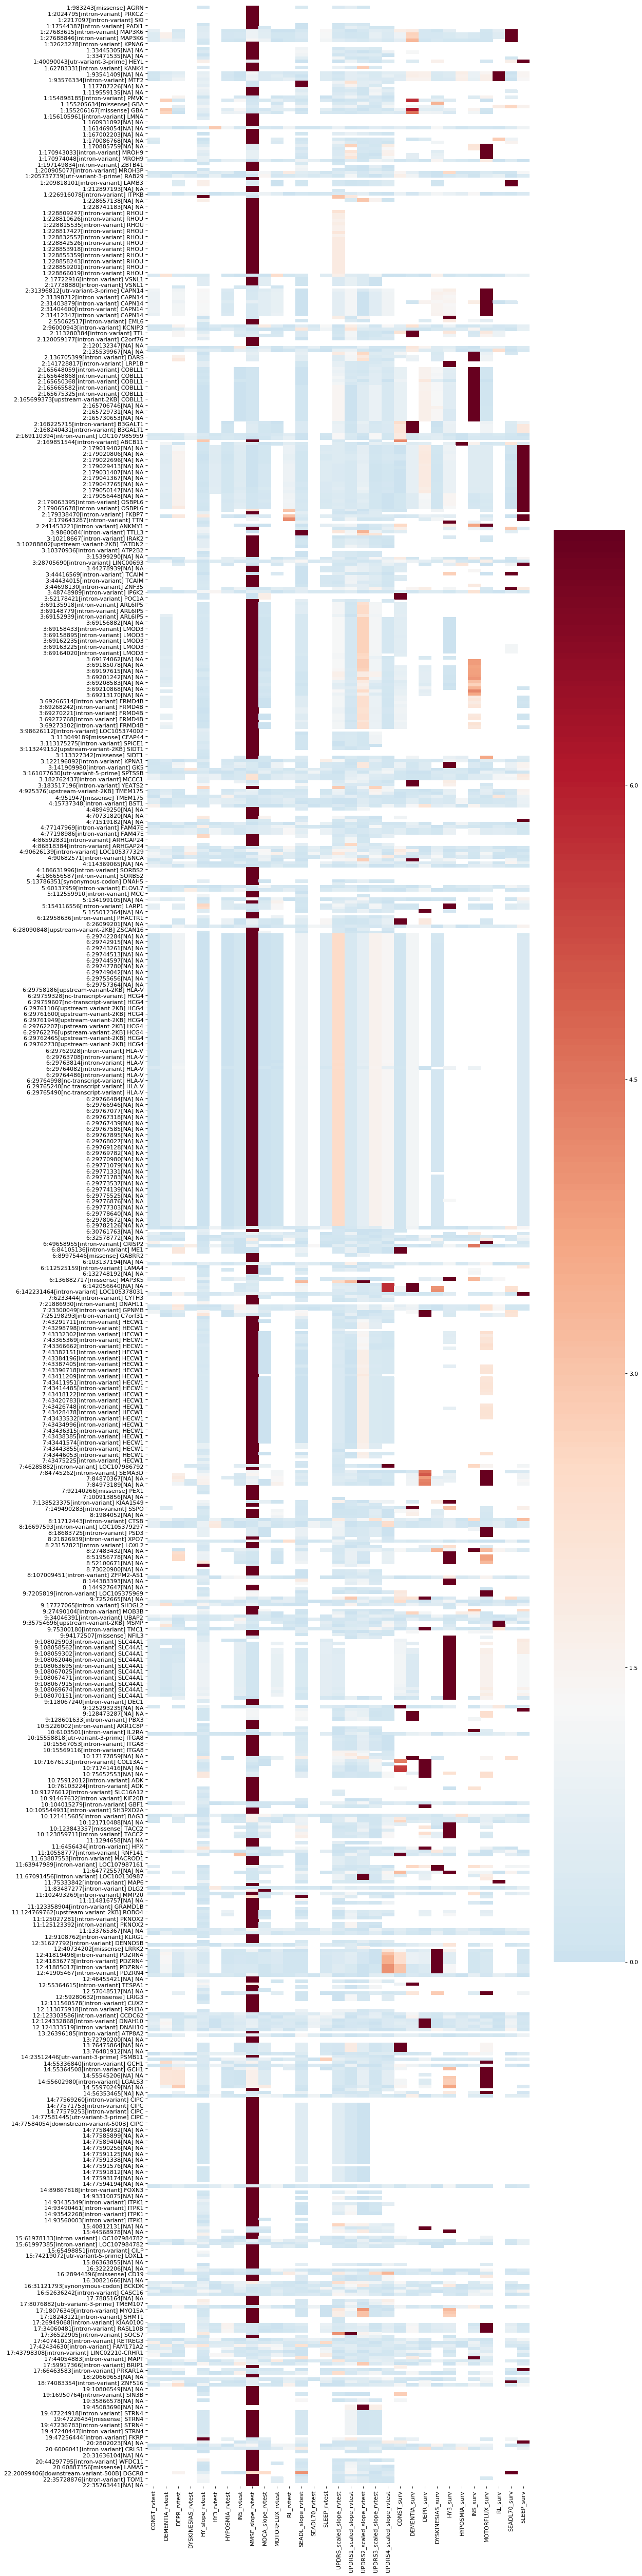

In [130]:
df_out = df.iloc[:, 1:(df.shape[1]-6)]
df_out.index = df['V1'] + "[" + df['FXNCLASS'] + "] " + df['SYMBOL']
df_out.head()

fig=plt.figure(figsize=(15, 80), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(df_out,cmap='RdBu_r', vmin=0, center=1.301, vmax=7.301)

When I look at the MMESE_slope, it has many hits but they don't overlap with other relevant outcomes (e.g. DEMENTIA_surv). I used a new algorithm for slope analysis (data projection to complementary orthogonal matirx) so I need to double check it with glmmm analysis I am running now (It would take a few days).    
To get idea from more confirmative results, ** I will remove variants only significant to the slope outcomes. **

In [149]:
df_wo_slope = df.loc[:,[i for i in list(df) if not "slope" in i]]
df_wo_slope_sig = (df_wo_slope.iloc[:, 1:(df_wo_slope.shape[1]-6)] > 7.301).sum(axis=1)
df_wo_slop_less = df_wo_slope.loc[df_wo_slope_sig>0]

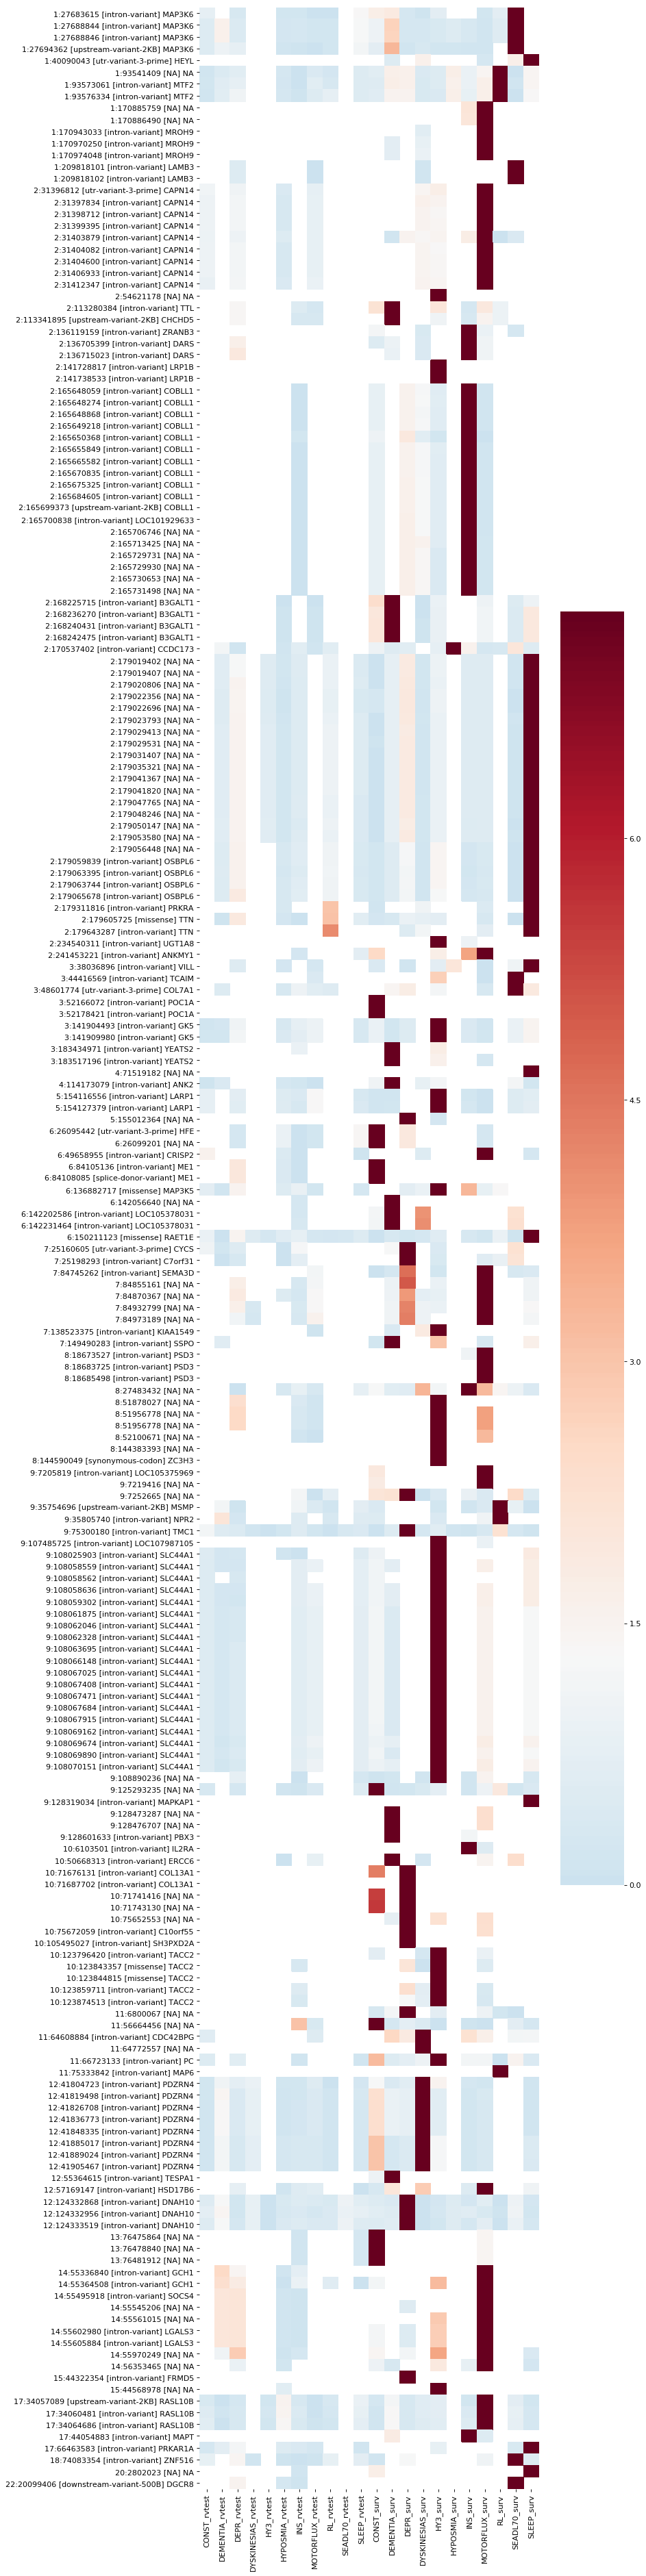

In [156]:
dft = df_wo_slop_less
dft_out = dft.iloc[:, 1:(dft.shape[1]-6)]
dft_out.index = dft['V1'] + " [" + dft['FXNCLASS'] + "] " + dft['SYMBOL']
dft_out.head()
fig=plt.figure(figsize=(10,60), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(dft_out,cmap='RdBu_r', vmin=0, center=1.301, vmax=7.301)

##### The following heatmap is for the 92 new-identified variants in Meta5

In [117]:
vMeta5 = pd.read_table("post/Meta5.list", names=['V1'])
vMeta5_loc = vMeta5['V1'].str[3:]
df_vMeta5_loc = key.to_frame('V1')
df_vMeta5 = df.merge(df_vMeta5_loc, on='V1')

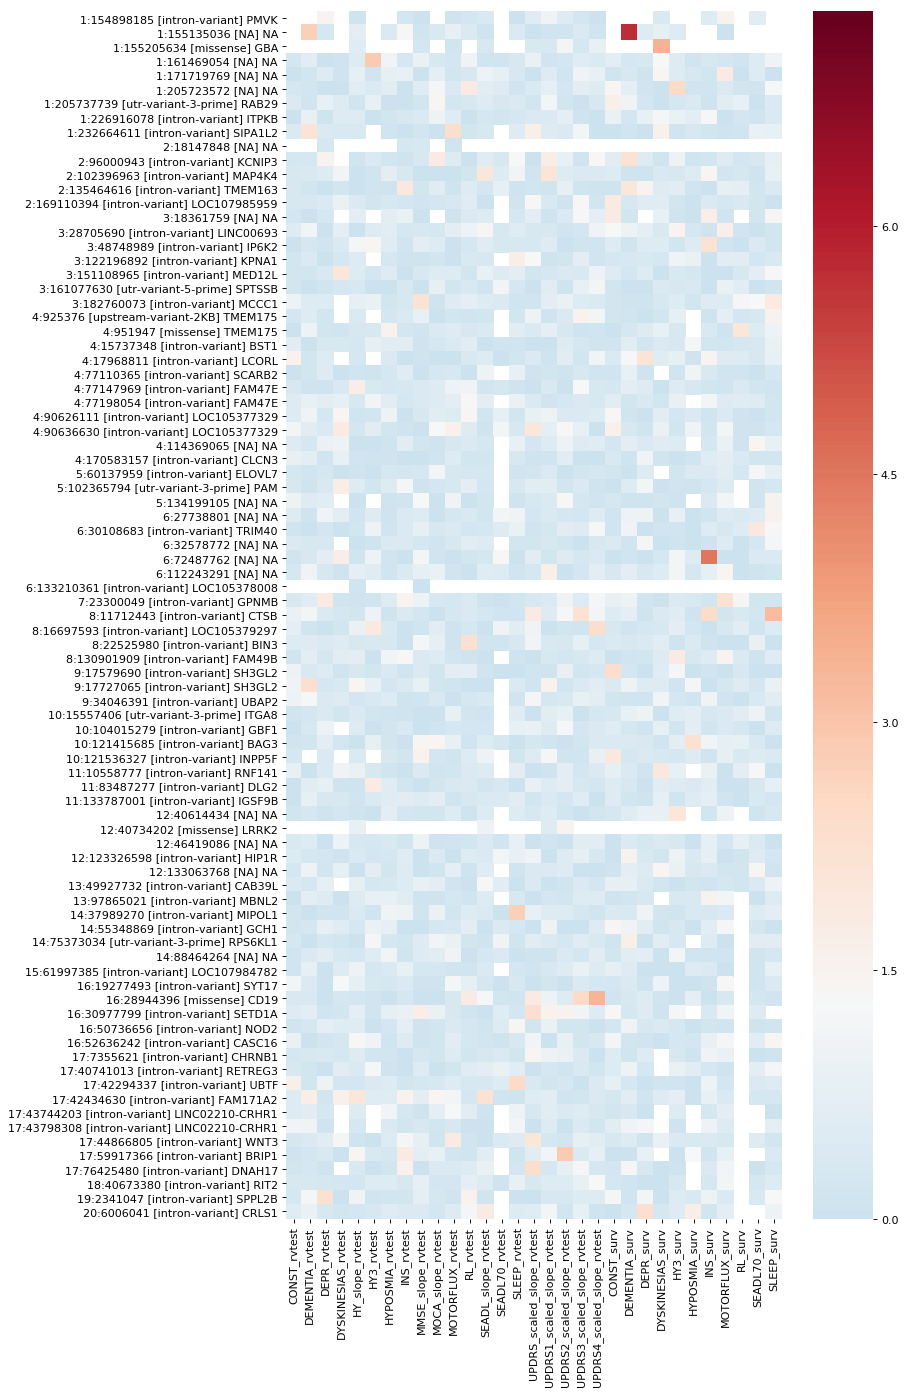

In [125]:
dft = df_vMeta5
dft_out = dft.iloc[:, 1:(dft.shape[1]-6)]
dft_out.index = dft['V1'] + " [" + dft['FXNCLASS'] + "] " + dft['SYMBOL']
dft_out.head()
fig=plt.figure(figsize=(10, 20), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(dft_out,cmap='RdBu_r', vmin=0, center=1.301, vmax=7.301)

We can see some red columns for those 92 snps. 